# Diffrential Privacy KMeans

In [1]:
import itertools as it

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.metrics import v_measure_score
from scipy.spatial.distance import cdist

sns.set(rc={'figure.figsize':(7, 7)})
sns.set_style('white')

In [2]:
CENTERS = np.array([(0, .5),
                    (.2, -.2),
                    (-.2, -.2)])

N_CLUSTERS = len(CENTERS)
CLUSTER_STD = 0.05
N_DATA = 2000

T = 10
COUNT_THRESHOLD = 5

In [3]:
def clip_by_l1_norm(X):
    """Clip datapoints into [-1,1]^d by L1 norm."""

    l1_norm = np.linalg.norm(X, ord=1, axis=-1)
    outside_points_mask = (l1_norm > 1)
    X[outside_points_mask, :] /= l1_norm[outside_points_mask,
                                         None]
    return X


def make_dataset(n_samples=N_DATA, centers=CENTERS, cluster_std=CLUSTER_STD):
    """Generate 2D dataset for clustering tasks, clipped into [-1,1]^2 by L1 norm."""
    X, y = make_blobs(n_samples,
                      2,
                      centers,
                      cluster_std,
                      shuffle=True)

    X = clip_by_l1_norm(X)

    return X, y


def generate_clustering_proposal(X, signle_iteration_centers):
    """Generate proposal (labeles) for each datapoint given centers."""
    
    distances_from_cetners = cdist(signle_iteration_centers, X)
    return np.argmin(distances_from_cetners, axis=0)


def kmeans_dp_2d(X, eps=float('inf'),
                 n_clusters=N_CLUSTERS, n_iteration=T,
                 count_threshold=COUNT_THRESHOLD):
    """Perform DP KMeans Algorithm in 2D."""

    assert eps > 0, 'eps should be in the range (0, ∞]'

    adjusted_eps = eps / (2 * n_iteration)
    scale_factor = 1 / adjusted_eps

    centers = np.zeros((n_iteration + 1, n_clusters, 2))
    
    # Random centers in [-1, 1]^2, clipped by L1 norm <= 1
    centers[0] = clip_by_l1_norm(np.random.uniform(-1, 1,
                                 size=(n_clusters, 2)))

    proposals = np.zeros((n_iteration + 1, len(X)), dtype='int')

    for iteration in range(1, n_iteration + 1):
        
        # Get a clustering proposal from the previous centers
        proposals[iteration - 1] = generate_clustering_proposal(X,
                                                                centers[iteration - 1])

        # Based on the proposal, calculate the new centers
        for cluster_id in range(n_clusters):
            cluster_mask = (proposals[iteration - 1] == cluster_id)

            # If there is at least one datapoint that was assigned to this cluster
            if cluster_mask.any():
                
                noisy_n_points = (cluster_mask.sum()
                                  + np.random.laplace(0, scale_factor))
                
                if noisy_n_points > count_threshold:
                    noisy_sum_points = (np.sum(X[cluster_mask], axis=0)
                                        + np.random.laplace(0, 2*scale_factor,
                                                            2))

                    nosy_center = noisy_sum_points / noisy_n_points
                    centers[iteration, cluster_id] = nosy_center

                else:
                    random_center = clip_by_l1_norm(np.random.uniform(-1, 1, 2))
                    centers[iteration, cluster_id] = random_center
                
                # Vanilla K-Means:
                # centers[iteration, cluster_id] = np.mean(X[cluster_mask],
                #                                           axis=0)

            else:
                # No datapoint was assigned to this cluster
                # so we will use the center from the last iteration
                centers[iteration, cluster_id] = centers[iteration-1,
                                                          cluster_id]

            centers[iteration] = clip_by_l1_norm(centers[iteration])

    proposals[iteration] = generate_clustering_proposal(X, centers[iteration])
    
    return centers, proposals

In [4]:
def plot_single_kmeans_dp_2d(X, y, eps, ax=None):
        
    centers, proposals = kmeans_dp_2d(X, eps)
    
    if ax is None:
        f, ax = plt.subplots(1)
    
    palette = sns.color_palette('deep', 3)

    # Plot scatter of the datapoints
    sns.scatterplot(X[:, 0], X[:, 1], hue=proposals[-1], alpha=0.1,
                    palette=list(np.take(palette, np.unique(proposals[-1]), axis=0)),
                    ax=ax)

    # Plot the trajectories of learned cluster centers along the iterations
    for cluster_id in range(N_CLUSTERS):
        ax.plot(centers[:, cluster_id, 0], centers[:, cluster_id, 1],
                 '--', c=palette[cluster_id], linewidth=2)

    # Plot released learned cluster centers
    ax.scatter(centers[-1, :, 0], centers[-1, :, 1], c='k', marker='X', s=100)

    # Plot data-generation ("true") cluster centers
    ax.scatter(CENTERS[:, 0], CENTERS[:, 1], c='k', marker='x', s=2000)

    # V-measure for quality of clustering with ground-truth
    # See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html
    v_measure = v_measure_score(y, proposals[-1])
    ax.set_title(f'v-score = {v_measure:.2f}')
    
    return ax


def plot_multiple_kmeans_dp_2d(eps, n_trials=9, figsize=(20, 20)):

    n_side = int(n_trials**0.5)
    assert n_side**2 == n_trials, ('n_trials should be a squre.'
                                   'We require that to have simple code for multiple subplots')
    
    X, y = make_dataset()

    
    f, axes = plt.subplots(n_side, n_side, figsize=figsize)
    
    for ax in it.chain(*axes):
        plot_single_kmeans_dp_2d(X, y, eps, ax)

    f.suptitle(f'ϵ = {eps}', fontsize=32)

    return f, axes

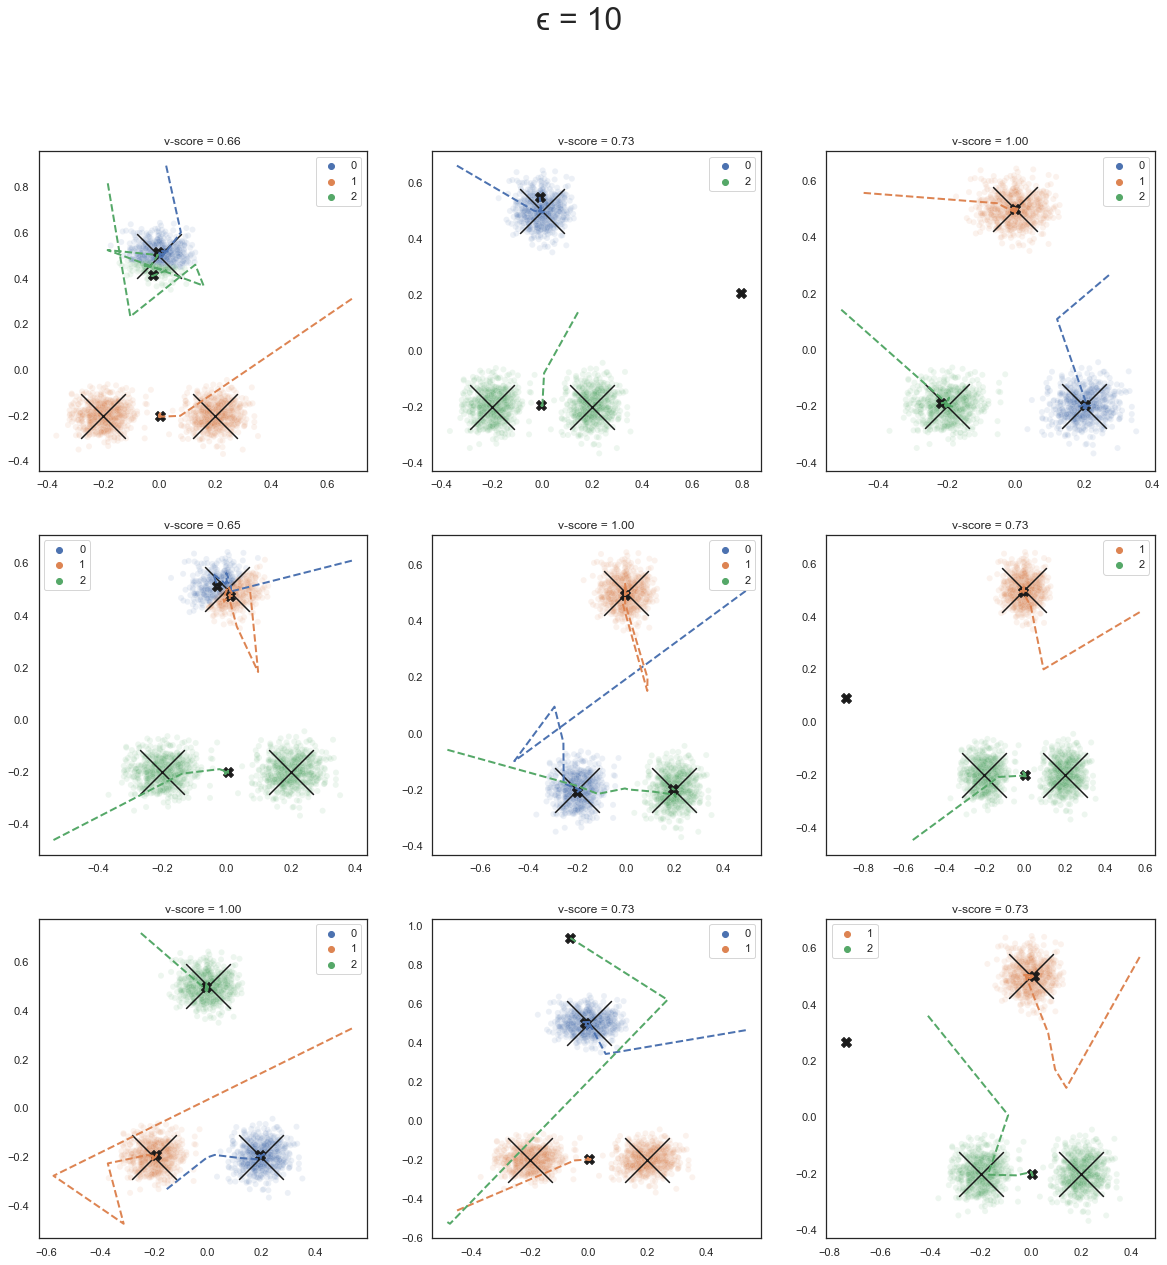

In [5]:
f, _ = plot_multiple_kmeans_dp_2d(10);
f.savefig('./plots/dp-kmeans-eps-10.png', dpi=300)

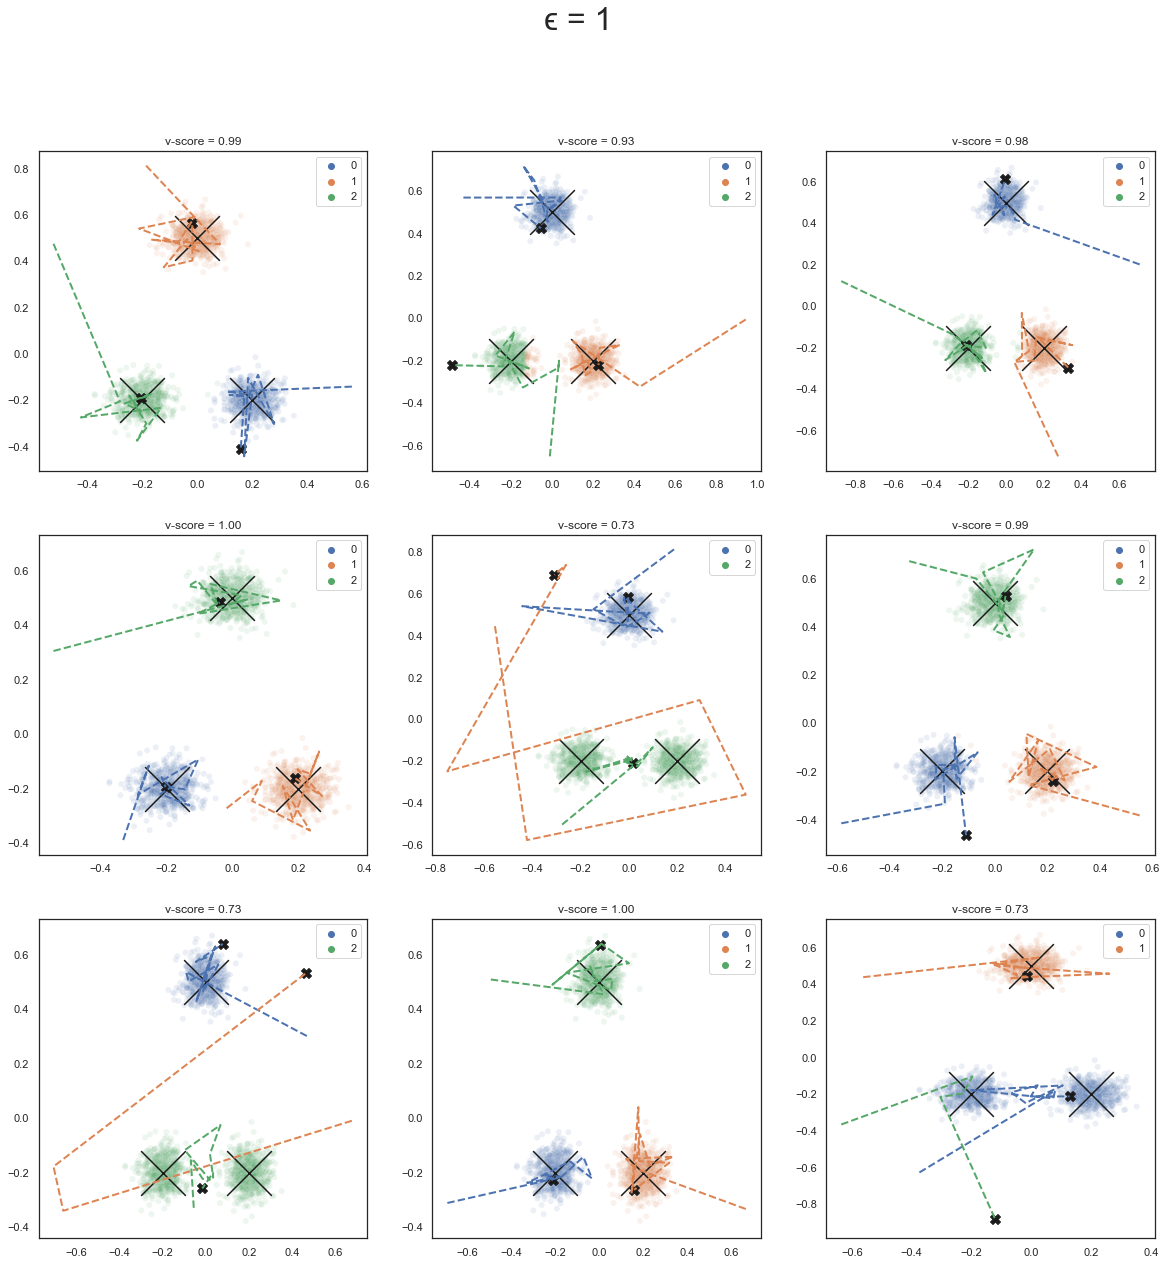

In [6]:
f, _ = plot_multiple_kmeans_dp_2d(1);
f.savefig('./plots/dp-kmeans-eps-1.png', dpi=300)

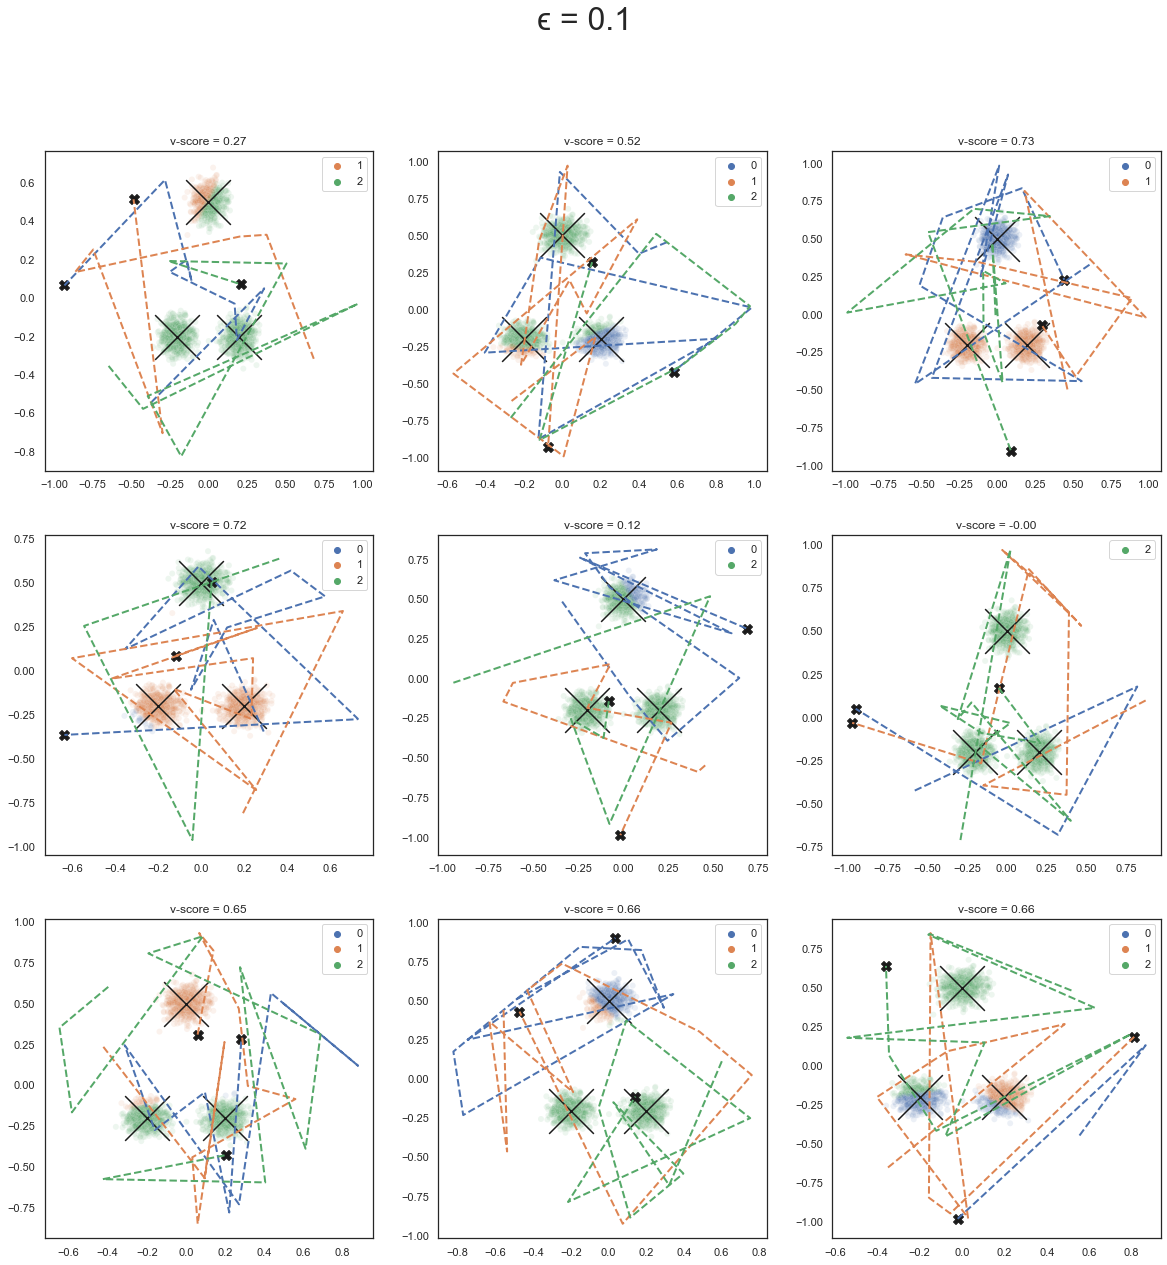

In [7]:
f, _ = plot_multiple_kmeans_dp_2d(0.1);
f.savefig('./plots/dp-kmeans-eps-01.png', dpi=300)